In [1]:
import train_network as tn
import frame_feature_extractor as ffe
import signal
import tensorflow as tf

from collections import deque
import cv2
import matplotlib as plt
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading

In [2]:
model = tf.saved_model.load('../saved_experiments/test_experiment')

# Set Hyperparameters

In [3]:
SEQ_LEN = 20
THRESHOLD = .6

# Stop button
# ================

In [6]:
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the fa- prefix)
)
def view(button):
    cap = cv2.VideoCapture(0)
    out = cv2.VideoWriter('./TestVideos/LiveTesting/LSTM/SIGMOID/all3_low.avi', cv2.VideoWriter_fourcc(*'XVID'), 25.0, (int(cap.get(3)), int(cap.get(4))))

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    display_handle=display(None, display_id=True)
    i = 0
    frame_queue = deque(maxlen=SEQ_LEN)

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = .5
    fontColor              = (0, 0,255)
    thickness              = 1
    lineType               = 2
    CLASS_LIST=['JumpingJack', 'PushUp', 'BodyWeightSquats']
    
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        height, width, channels = frame.shape

        resized_frame = cv2.resize(frame, (256, 256))
        frame_features = ffe.get_features_from_image(resized_frame)
        frame_queue.append(tf.keras.layers.Flatten()(frame_features))
        if len(frame_queue)<SEQ_LEN:
            if len(frame_queue)%10 == 0: print(len(frame_queue))
            continue
        x = tf.convert_to_tensor(list(frame_queue))
        x = tf.transpose(x, perm=[1, 0, 2])

#         for p in range(1):
#             for f in frame_features[0][p]:
#                 if f[2] > THRESHOLD:
#                     frame = cv2.circle(frame, (int(f[1]*width), int(f[0]*height)), radius=2, color=(0, (0 if p<1 else 255), 255), thickness=-1)
        
        if len(frame_queue) == SEQ_LEN:
            predicted_label_probabilities = model(x)[0]
            
            predicted_label = np.argmax(predicted_label_probabilities)
            predicted_class = CLASS_LIST[predicted_label]
        
        cv2.putText(frame, str(predicted_label_probabilities), (10, 30), cv2.FONT_HERSHEY_SIMPLEX,1, (0, 0, 255), 2)

        out.write(frame)
        ret, frame = cv2.imencode('.jpeg', frame)

        display_handle.update(Image(data=frame.tobytes()))
        if stopButton.value:
            cap.release()
            out.release()
            display_handle.update(None)
            cv2.destroyAllWindows()
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Run
# ================

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

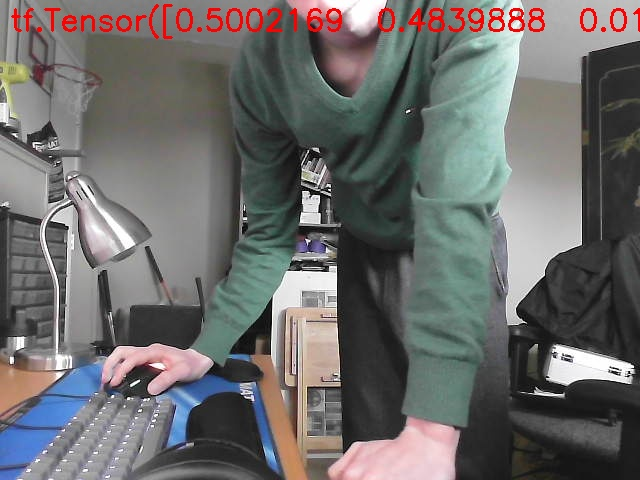

10


In [7]:
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()